In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import PIL.Image

In [ ]:
import pathlib
from pathlib import Path
data_dir = Path("/content/drive/MyDrive/maize_disease_classification/data")

In [ ]:
def count_img(folder):
  image_count = len(list(folder.glob('*.JPG')))
  image_count += len(list(folder.glob('*.jpg')))
  image_count += len(list(folder.glob('*.jpeg')))
  return image_count


In [ ]:
class_counts={}
total_img=0

for class_folder in data_dir.iterdir():
  count = count_img(class_folder)
  class_counts[class_folder.name] = count
  total_img += count

print(class_counts, total_img)


{'Healthy': 1162, 'Blight': 1146, 'Gray_Leaf_Spot': 574, 'Common_Rust': 1306} 4188


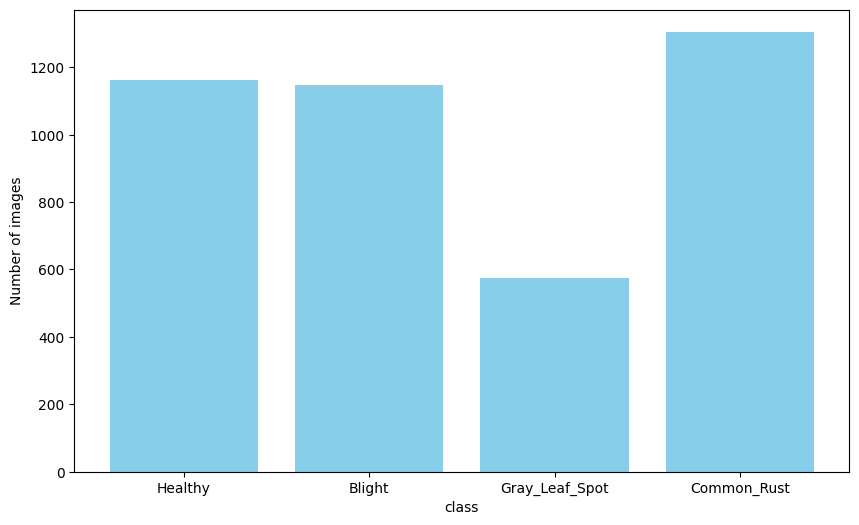

In [ ]:
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10,6))
plt.bar(classes, counts, color="skyblue")
plt.xlabel("class")
plt.ylabel("Number of images")
plt.show()

In [ ]:
batch_size = 16
img_height = 256
img_width = 256

In [ ]:
import tensorflow as tf

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 4188 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


(256, 256, 3) Healthy


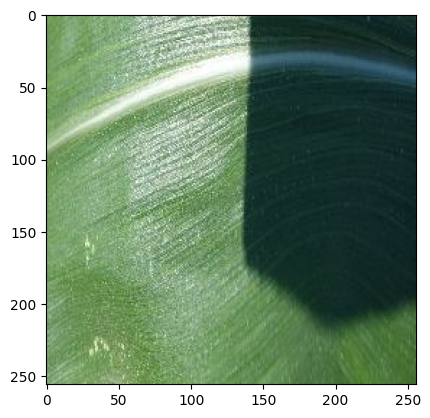

In [ ]:
for images, labels in dataset.take(1):
  image = images[0]
  label = labels[0]

  print(image.shape, class_names[label])

  plt.imshow(image.numpy().astype("uint8"))
  plt.show()

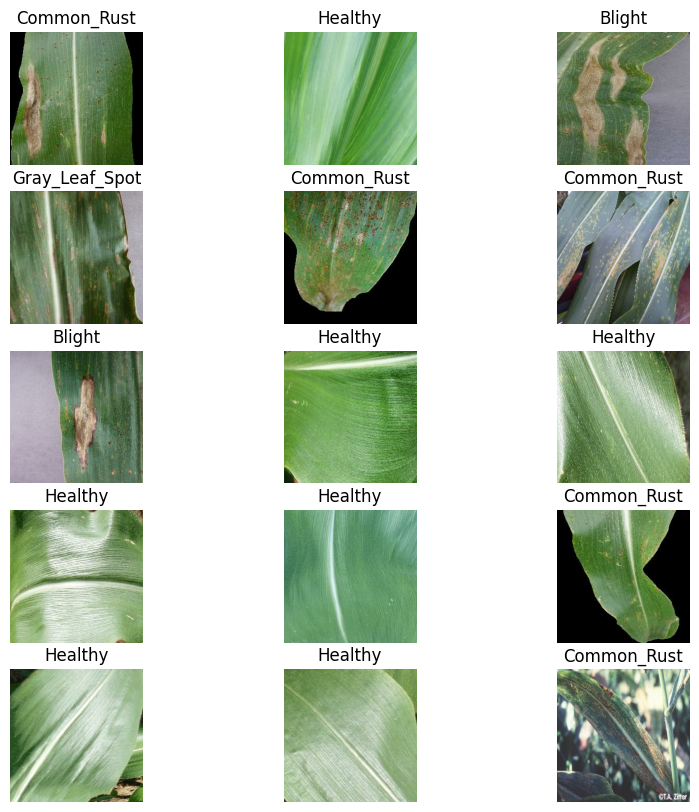

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(15):
    ax = plt.subplot(5,3,i+1)
    plt.imshow(images[i].numpy().astype("uint"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)


Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Class names:", class_names)
num_classes = len(class_names)

Class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
from tensorflow.keras import layers, models

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# model = models.Sequential([
#     layers.InputLayer(input_shape=(img_height, img_width, 3)),

#     layers.Conv2D(32, (3,3), activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D(),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation='softmax')
# ])

# model.summary()


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(256,256,3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.summary()


/tmp/ipython-input-1151454616.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256,256,3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,108 (8.77 MB)

 Trainable params: 41,124 (160.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',       # monitor validation loss
    patience=3,               # stop after 3 epochs with no improvement
    restore_best_weights=True # roll back to the best model
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.6558 - loss: 0.8073 - val_accuracy: 0.8877 - val_loss: 0.2919
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8523 - loss: 0.3704 - val_accuracy: 0.9032 - val_loss: 0.2417
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8801 - loss: 0.2945 - val_accuracy: 0.9032 - val_loss: 0.2318
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8984 - loss: 0.2648 - val_accuracy: 0.9116 - val_loss: 0.2266
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8954 - loss: 0.2519 - val_accuracy: 0.9020 - val_loss: 0.2165
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9150 - loss: 0.2202 - val_accuracy: 0.8961 - val_loss: 0.2336
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9187 - loss: 0.2119 - val_accuracy: 0.9044 - val_loss: 0.2272
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9056 - loss: 0.2198 - val_accu

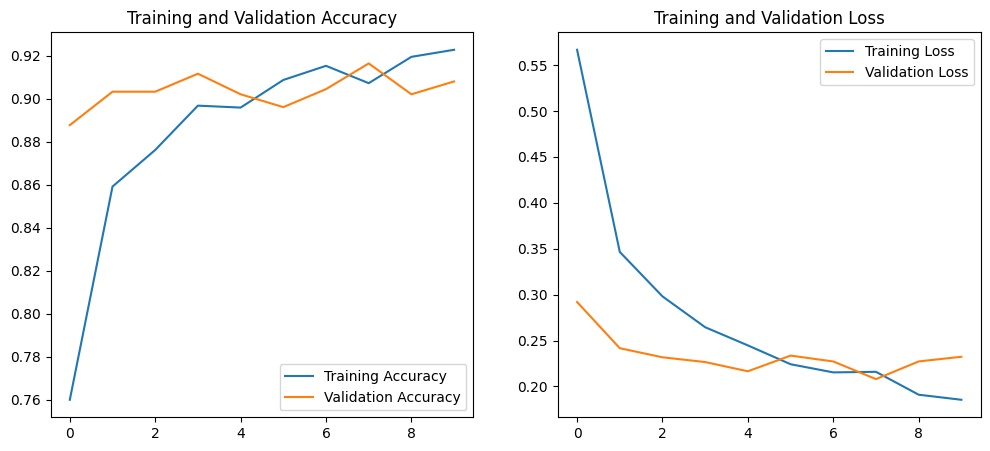

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/maize_disease_classification/model/maize_disease_model_v3.keras"

In [ ]:
model.save(model_path)

In [ ]:
test_image_path = "/content/drive/MyDrive/maize_disease_classification/data/Corn_Blight (973).jpg"

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img(test_image_path, target_size=(256,256))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 256, 256, 3)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

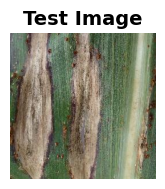

In [ ]:
ax1 = plt.subplot(1, 3, 1)
original_img = image.load_img(test_image_path)
plt.imshow(original_img)
plt.title(f'Test Image', fontsize=14, fontweight='bold')
plt.axis('off')

In [ ]:
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(predicted_class, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Blight 88.921646
